# Lesson 2: Bird Identification

This is a quick attemp to use Bing API to obtain images of birds to train a model that can attempt to identify a type of bird based on searches online

In [1]:
# Import Modules
import fastbook
import os

In [2]:
fastbook.setup_book

<function fastbook.setup_book()>

In [3]:
from fastbook import *

## API

In [5]:
Bing_API = '2bf16b82e4544648aeac2d54d585b7c6'
key = os.environ.get('AZURE_SEARCH_KEY', Bing_API)

In [6]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [7]:
results = search_images_bing(key, 'bird') #searching bing for 'bird'
ims = results.attrgot('contentUrl')
len(ims)

150

In [8]:
ims

(#150) ['https://wallup.net/wp-content/uploads/2019/09/453527-parrot-bird-beak.jpg','https://www.hdnicewallpapers.com/Walls/Big/Parrot/Amusing_Macaw_Parrot_Bird_Wallpaper.jpg','https://wallup.net/wp-content/uploads/2018/10/07/766909-warbler-bird-birds-nature-wildlife.jpg','https://wallup.net/wp-content/uploads/2018/10/07/363313-parakeet-budgie-parrot-bird-tropical-45.jpg','https://www.wallpapers13.com/wp-content/uploads/2016/02/Blue-bird-Parrot-macaw-hd-wallpaper-1680x1050.jpg','https://wallup.net/wp-content/uploads/2019/09/363402-lory-parrot-bird-tropical-34.jpg','https://wallup.net/wp-content/uploads/2019/09/363352-eclectus-parrot-bird-tropical-20.jpg','https://wallup.net/wp-content/uploads/2018/10/07/363978-finch-bird-finches-10-jpg.jpg','https://hddesktopwallpapers.in/wp-content/uploads/2015/08/toucan-bird-wallpaper.jpg','https://wallup.net/wp-content/uploads/2019/09/363251-parakeet-budgie-parrot-bird-tropical-61.jpg'...]

In [9]:
test_image = ['https://wallup.net/wp-content/uploads/2019/09/453527-parrot-bird-beak.jpg']

In [10]:
dest = 'images/parrot.jpg'
download_url(test_image[0], dest)

Path('images/parrot.jpg')

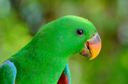

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

In [12]:
bird_types = 'parrot','toucan','parakeet','crow','eagle'
path = Path('bird')

In [13]:
if not path.exists():
    path.mkdir()
    for t in bird_types:
        dest = (path/t)
        dest.mkdir(exist_ok=True)
        results=search_images_bing(key,f'{t} bird')
        download_images(dest, urls =results.attrgot('contentUrl'))

## Clean

In [14]:
fns = get_image_files(path)
fns

(#675) [Path('bird/toucan/00000047.jpg'),Path('bird/toucan/00000055.jpg'),Path('bird/toucan/00000036.jpg'),Path('bird/toucan/00000030.jpg'),Path('bird/toucan/00000097.jpg'),Path('bird/toucan/00000148.jpg'),Path('bird/toucan/00000110.jpg'),Path('bird/toucan/00000029.jpg'),Path('bird/toucan/00000112.jpg'),Path('bird/toucan/00000091.jpg')...]

In [15]:
failed = verify_images(fns)
failed

(#0) []

In [16]:
failed.map(Path.unlink);

## DataLoader

In [17]:
birds = DataBlock(
    blocks =(ImageBlock, CategoryBlock), #Image is our independent and #Category is our dependent
    get_items = get_image_files, #function that takes a path and returns a list of images in that path
    splitter = RandomSplitter(valid_pct=0.2, seed=42), #splitting into validation & training and giving a standardized point
    get_y = parent_label, #telling fastai what function to call to create labels #parent_label gets name of folder the image is in
    item_tfms=Resize(128)) #gives DataBlock object; template for creating `DataLoaders`

In [18]:
dls = birds.dataloaders(path)

### Checking images

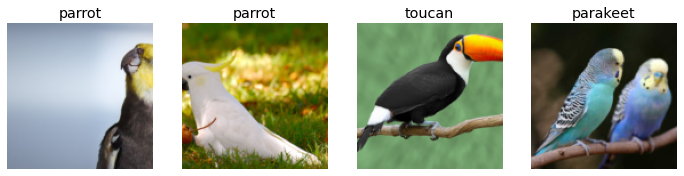

In [19]:
dls.valid.show_batch(max_n = 4, nrows = 1)

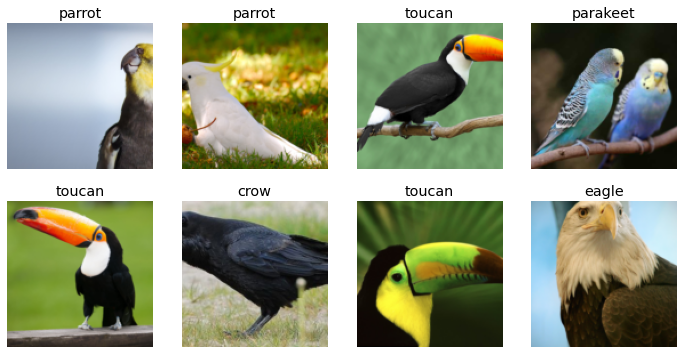

In [20]:
dls.valid.show_batch(max_n = 8, nrows = 2)

Looks good!!!!!!!!!

### Data Augmentation

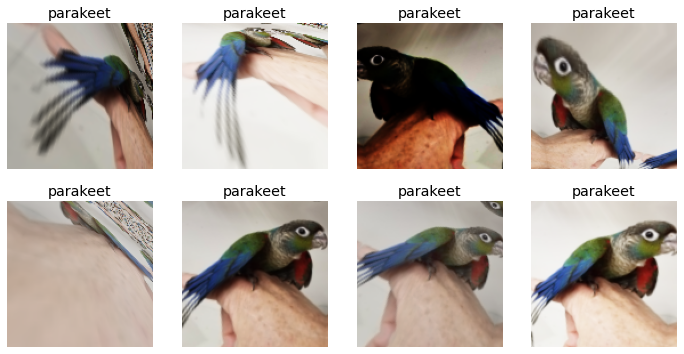

In [21]:
birds = birds.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult=3))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

## Train Model

In [22]:
birds = birds.new(
    item_tfms = RandomResizedCrop(224,min_scale=0.5), #crop to 224 pixels (standard)
    batch_tfms=aug_transforms())
dls=birds.dataloaders(path)

### Create Learner to fine-tune

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.779042,0.412501,0.185185,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.571880,0.198118,0.081481,00:21
1,0.448476,0.189957,0.088889,00:21
2,0.360937,0.202944,0.074074,00:21
3,0.317072,0.200500,0.074074,00:21


### Checking Mistakes

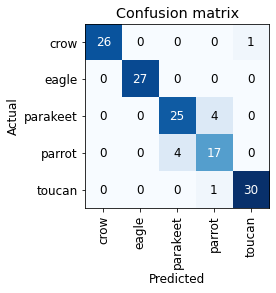

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

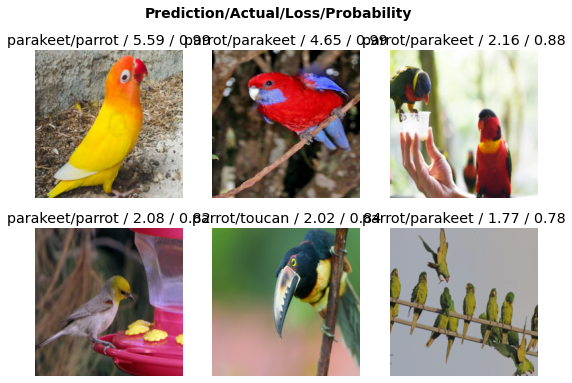

In [25]:
#Checking based on LOSS
#sorting images by LOSS
interp.plot_top_losses(6,nrows=2)

Lets look at the very first image (top-left):

* Predicted: toucan
* Labeled (by bing): parrot

We need to change the labels!

## Cleaning Part II

In [4]:
#Import widgets tool for this!
from fastai.vision.widgets import *

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
# Getting rid and updating parrot and training stuff
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Re-Train

In [55]:
birds = birds.new(
    item_tfms = RandomResizedCrop(224,min_scale=0.5), #crop to 224 pixels (standard)
    batch_tfms=aug_transforms())
dls=birds.dataloaders(path)

In [56]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.947099,0.413318,0.105263,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.483001,0.273155,0.090226,00:22
1,0.377634,0.215579,0.075188,00:24
2,0.301234,0.228911,0.082707,00:23
3,0.254920,0.239265,0.090226,00:21


### Loss

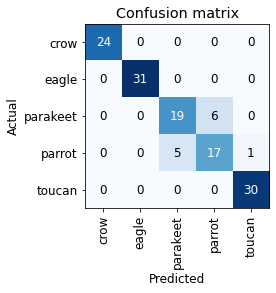

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

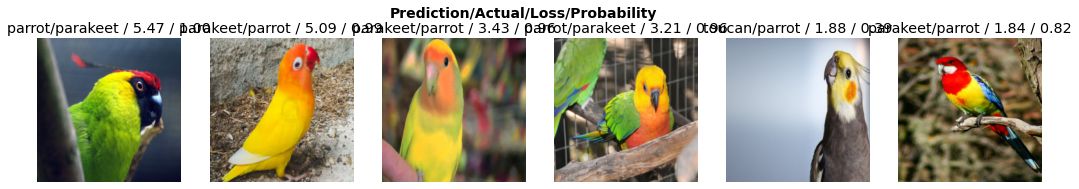

In [58]:
interp.plot_top_losses(6,nrows=1)

In [59]:
cleaner_second = ImageClassifierCleaner(learn)
cleaner_second

In [54]:
for idx in cleaner_second.delete(): cleaner_second.fns[idx].unlink()
#for idx,cat in cleaner_second.change(): shutil.move(str(cleaner_second.fns[idx]), path/cat)

FileNotFoundError: [Errno 2] No such file or directory: 'bird/parakeet/00000103.jpg'

In [36]:
cleaner_second = ImageClassifierCleaner(learn)
cleaner_second

# Deploying Model into Application

## Exporting Model

In [60]:
learn.export() #saves a `.pkl` file

In [5]:
# checking to see if file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [6]:
learn_inf = load_learner(path/'export.pkl') #creating inference learner from exported file using load_learner

In [7]:
# learn_inf.predict('images/bird.jpg')
learn_inf.dls.vocab #checking categories

['crow', 'eagle', 'parakeet', 'parrot', 'toucan']

## Creating Widget

In [8]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [9]:
# getting image to test out stuff
img = ['https://wallup.net/wp-content/uploads/2019/09/453527-parrot-bird-beak.jpg']
dest = 'images/parrot.jpg'
download_url(ims[0],dest)

NameError: name 'ims' is not defined

In [10]:
im = Image.open(dest)

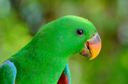

In [11]:
im.to_thumb(128,128)

In [12]:
btn_upload = SimpleNamespace(data=['images/parrot.jpg'])

In [13]:
img = PILImage.create(btn_upload.data[-1])

In [14]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [15]:
pred,pred_idx,probs = learn_inf.predict(img)

In [16]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: parrot; Probability: 0.7761')

In [17]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [18]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
        
btn_run.on_click(on_click_classify)

In [19]:
btn_upload = widgets.FileUpload()

In [20]:
VBox([widgets.Label('Select your bird!'),
     btn_upload, btn_run, out_pl, lbl_pred])

### Turning Notebook into Application

In [21]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.14 OK
